In [1]:
%matplotlib widget
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from scipy.interpolate import interp1d
import scipy
import twixtools 
from fsl_mrs.utils.preproc.combine import svd_reduce, weightedCombination
import scipy.signal.windows as ssw
from scipy.integrate import cumulative_trapezoid
from fsl_mrs.utils.plotting import FID2Spec
from scipy.interpolate import CubicSpline
from ipywidgets import interact, FloatSlider
from matplotlib.ticker import FuncFormatter
from scipy.signal import butter, filtfilt
import fsl_mrs.utils.mrs_io as mrs_io
from fsl_mrs.utils.preproc import nifti_mrs_proc as proc
from nifti_mrs.create_nmrs import gen_nifti_mrs_hdr_ext
import ipywidgets as w
from scipy.interpolate import PchipInterpolator, Akima1DInterpolator
import fsl_mrs

c:\Users\james\miniconda3\envs\fsl_mrs\Lib\site-packages\twixtools\recon_helpers.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
#Functions to read the simulated input graidents from POET sequence simulation tool

def dsv2timecourse(dsv, truncated):
    """
    Process DSV compressed time-series data.
    
    :param dsv: Parsed DSV dictionary from dsvRead.
    :param truncated: If True, disables sample count validation.1
    :return: (t, y) -> Time values and signal values.
    """
    values = np.array(dsv.get('VALUES', []), dtype=float)
    if values.size == 0:
        return np.array([]), np.array([])
    
    t = np.full(values.shape, np.nan)
    y = np.full(values.shape, np.nan)
    
    t[0] = 1
    y[0] = values[0]
    
    count = 1
    idx = 0
    this_y_deriv = 0
    
    while idx < len(values) - 1:
        idx += 1
        count += 1
        last_y_deriv = this_y_deriv
        this_y_deriv = values[idx]
        
        if this_y_deriv == last_y_deriv:
            idx += 1
            if idx >= len(values):
                break
            reps = int(values[idx]) + 1
        else:
            reps = 1
        
        t[count - 1] = t[count - 2] + reps
        y[count - 1] = y[count - 2] + reps * this_y_deriv
    
    vert_factor = float(dsv['DEFINITIONS'].get('VERTFACTOR', 1))
    horidelta = float(dsv['DEFINITIONS'].get('HORIDELTA', 1))
    samples = int(dsv['DEFINITIONS'].get('SAMPLES', count))
    
    y = y[:count] / vert_factor
    t = t[:count] * horidelta
    
    if not truncated and t[-1] != samples:
        raise ValueError("Sample count mismatch.")
    
    return t, y

def dsv_read(file_path, plot=True, max_lines=None):
    """
    Reads a Siemens simulator .DSV file and returns the parsed data.
    
    :param file_path: Path to the .dsv file.
    :param plot: If True, plot the data.
    :param max_lines: Maximum number of data lines to read.
    :return: (t, y, dsv) -> Time values, signal values, and full parsed dictionary.
    """
    dsv = {}
    current_section = None
    
    with open(file_path, 'r', encoding='latin-1') as file:
        for line in file:
            line = line.strip()
            
            if line.startswith('[') and line.endswith(']'):
                current_section = line[1:-1]
                dsv[current_section] = {}
            elif '=' in line:
                key, value = line.split('=', 1)
                dsv[current_section][key.strip()] = value.strip()
            elif line and re.match(r'^[0-9.\-]+$', line):
                if isinstance(dsv[current_section], dict):
                    # If it's a dictionary, convert it to a list for values
                    dsv[current_section] = []
                dsv[current_section].append(float(line))
                if max_lines and len(dsv[current_section]) >= max_lines:
                    break
    
    t, y = dsv2timecourse(dsv, max_lines is not None)
    t= t/1e6
    
    if plot:
        horidelta = float(dsv['DEFINITIONS'].get('HORIDELTA', 1))
        plt.figure()
        plt.plot(t , y, 'r-')
        #plt.xlabel(dsv['DEFINITIONS'].get('HORIUNITNAME', 'Time'))
        plt.xlabel('Time/S')
        plt.ylabel(dsv['DEFINITIONS'].get('VERTUNITNAME', 'Amplitude'))
        plt.title(dsv['DEFINITIONS'].get('TITLE', 'DSV Data'))
        plt.show()
    
    return t, y, dsv

#Resample gradients to the dwell time of the readout for ease of FT in later steps

def resample(t, y): 
    timeinterval = 5e-6
    time = np.arange(0, max(t)+timeinterval/2, timeinterval)

    f = interp.interp1d(t, y, kind='linear', fill_value="extrapolate")  # linear interpolation
    new_y = f(time)


    time = time[0:]
    new_y = new_y[0:]


    return time, new_y

#Function for time-alignment of the FID and phase error after integration

def shift_half_index_spline(array, shift):
    N = len(array)
    x = np.arange(N)
    spline = CubicSpline(x, array, bc_type='natural')
    x_shifted = x +shift   
    return spline(x_shifted)  # Evaluate shifted function

#Sinc function filter to account for the finite sampling in the ADC readout 

def custom_sinc_function(t=5e-6, length=1000):

    # Create frequency vector
    f = np.fft.fftshift(np.fft.fftfreq(length, t))

    # Compute sinc(tf) safely
    x = t * f
    y = np.sinc(x)  # np.sinc(x) = sin(pi*x)/(pi*x)

    return y

C:\Users\james\OneDrive - Nexus365\NWS_Code_Data


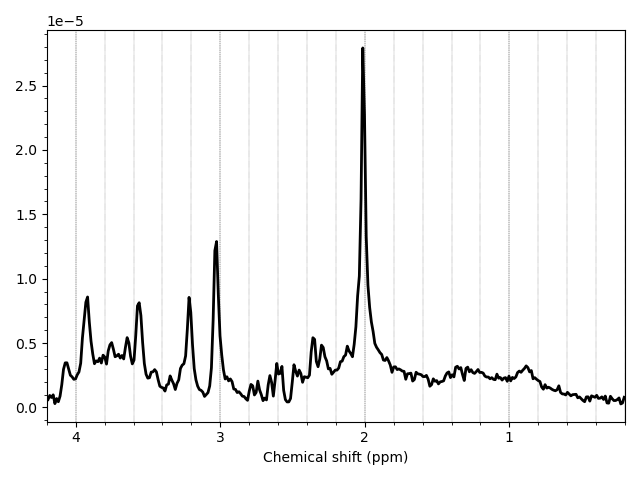

In [3]:
from pathlib import Path

# Path to the directory 
NOTEBOOK_DIR = Path().resolve()
print(NOTEBOOK_DIR)

part = '004'

#Load in preprocessed data following spec2nii (https://github.com/wtclarke/spec2nii) of the twix files and sLaser_preproc of those

final_sup  = mrs_io.read_FID(rf'{NOTEBOOK_DIR}/Data_for_correction/sLaser_preproc/{part}/sup_preproc.nii.gz')
unsupp_data4 = mrs_io.read_FID(rf'{NOTEBOOK_DIR}/Data_for_correction/sLaser_preproc/{part}/unsup_preproc.nii.gz')
#Data after system heating
#unsupp_data4 = mrs_io.read_FID(rf'{NOTEBOOK_DIR}/Data_for_correction/sLaser_preproc/unsup_preproc_diffusion.nii.gz')


#Plot suppressed data for sanity check 
plt.figure()
_ = final_sup.plot()

In [4]:

#Extract data for GIRF correction as numpy arrays
dataWS = np.conj(final_sup[0,0,0,:])
dataNoWS = np.conj(unsupp_data4[0,0,0,:])

In [5]:
#Truncation used in preprocessing
N=4
N1=4

#Time step based off the bandwidth
#timeNoWS are the timepoints of the readout period, readout starts at 0.8572 seconds for this sequence 

time_step = 0.0001666/2
timeNoWS = np.arange(N*time_step + 0.8572, (len(dataWS)+N)*time_step+0.8572 - time_step/2, time_step)
freqNoWS = np.fft.fftshift(np.fft.fftfreq(len(dataNoWS), d=time_step))
freqWS =np.fft.fftshift(np.fft.fftfreq(len(dataWS), d=time_step))

#Convert frequencies into ppm
freqNoWS=freqNoWS/(123.224196)
freqWS=freqWS/(123.224196)


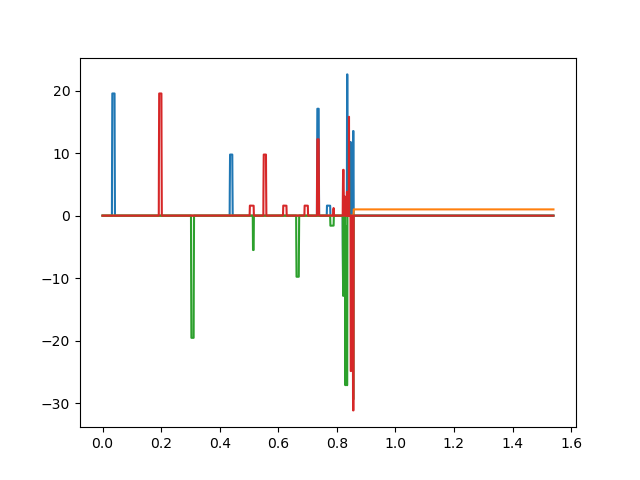

In [6]:
#Load in gradients and resample to the dwell time 

file_path = rf'{NOTEBOOK_DIR}/Data_for_correction/gradients_sLaser/SimulationProtocol_ADC.dsv'
t, y, dsv = dsv_read(file_path, plot=False, max_lines=10000)
time, new_y = resample(t, y)

max_index = int(max(time)/5e-6)


file_path = rf'{NOTEBOOK_DIR}/Data_for_correction/gradients_sLaser/SimulationProtocol_GRX.dsv'
t, y, dsv = dsv_read(file_path, plot=False, max_lines=10000)
time, gradX = resample(t, y)

file_path = rf'{NOTEBOOK_DIR}/Data_for_correction/gradients_sLaser/SimulationProtocol_GRY.dsv'
t, y, dsv = dsv_read(file_path, plot=False, max_lines=10000)
time, gradY = resample(t, y)

file_path = rf'{NOTEBOOK_DIR}/Data_for_correction/gradients_sLaser/SimulationProtocol_GRZ.dsv'
t, y, dsv = dsv_read(file_path, plot=False, max_lines=10000)
time, gradZ = resample(t, y)


#Use of only the first TR

gradX = gradX[:max_index+1]
gradY = gradY[:max_index+1]
gradZ = gradZ[:max_index+1]

#Plot gradients during readout

time2 = np.arange(0, len(gradX)*5e-6, 5e-6)
plt.figure()
plt.plot(time2, gradX)
plt.plot(time2, new_y)
plt.plot(time2, gradY)
plt.plot(time2, gradZ)

#Zero pad end to avoid cyclic artefacts from the Fourier Transform in next step
#Specific number is chosen so the length is an interger mutiple of the number of points in the GIRF, 39993, so interpolation works smoothly

gradX = np.pad(gradX, (0,241975), mode='constant')
gradY = np.pad(gradY, (0,241975), mode='constant')
gradZ = np.pad(gradZ, (0,241975), mode='constant')


time = time[:max_index+1]


In [7]:
#Mutiply the Input gradients by the GIRF in the frequency domain and IFT back to the time domain

#5Hz resolution on GIRF B0 and self terms 
P = 39993
#Order of Spherical Harmonics
order=1

def get_predicted_grad(input, dir, order):

    gradInputFT = np.fft.fftshift(np.fft.fft(input))
    #Filter to reduce high frequency noise 
    filter = ssw.tukey(len(gradInputFT), alpha =0.93)**25

    default_file_path = rf'{NOTEBOOK_DIR}\GIRF_measurements\Results39993/SphericalHarmonics_{dir.upper()}_{order}.npz'
    alt_P =19999
    #10Hz reolusiton for cross terms
    alt_file_path = rf'{NOTEBOOK_DIR}\GIRF_measurements\Results19999/SphericalHarmonics_{dir.upper()}_{order}.npz'

    grad_pred = []
    for i in range(4):
        # decide whether this iteration should use the alternate P/file
        use_alt = False
        if dir == 'y' and (i == 1 or i == 3):
            use_alt = True
        if dir == 'x' and (i == 2 or i == 3):
            use_alt = True
        if dir == 'z' and (i == 1 or i == 2):
            use_alt = True

        # choose file path and P for this iteration
        if use_alt:
            file_path = alt_file_path
            current_P = alt_P
        else:
            file_path = default_file_path
            current_P = P

        npz_data = np.load(file_path)
        GIRF_FT = npz_data.get('GIRF_FT', None)
        GIRF_FT = np.mean(GIRF_FT, axis=2)

        customsinc = custom_sinc_function(5e-6, current_P)
        #Dwell time filter
        GIRF_FT1 = GIRF_FT[i,:]/customsinc
        f = np.fft.fftshift(np.fft.fftfreq(current_P, 5e-6))
 

        x_original = np.linspace(0, 1, current_P)
        x_target   = np.linspace(0, 1, len(gradInputFT))


        #Interpolate GIRF to same number of points as input gradients for mutiplication
        #If the spectrum is complex, interpolate real & imag separately:
        p_real  = Akima1DInterpolator(x_original, np.real(GIRF_FT1))
        p_imag  = Akima1DInterpolator(x_original, np.imag(GIRF_FT1))
        girf_interpolated = p_real(x_target) + 1j*p_imag(x_target)


        #Separate out cross terms
        if dir =='y' and (i == 1 or i == 3) :
            interp_func = interp1d(x_original, GIRF_FT1, kind='linear', fill_value="extrapolate")
            girf_interpolated = interp_func(x_target)

        if dir =='x' and (i == 2 or i == 3) :
            interp_func = interp1d(x_original, GIRF_FT1, kind='linear', fill_value="extrapolate")
            girf_interpolated = interp_func(x_target)


        if dir =='z' and (i == 1 or i == 2) :
            interp_func = interp1d(x_original, GIRF_FT1, kind='linear', fill_value="extrapolate")
            girf_interpolated = interp_func(x_target)

        #Mutiplicaton in frequency domain, and by filter to reduce high frequency noise 

        gradOutputFTPred = girf_interpolated* gradInputFT *filter
        gradOutputPred = np.fft.ifft(np.fft.ifftshift(gradOutputFTPred))
        grad_pred.append(gradOutputPred)

    #Return predicted gradient field
    return np.asarray(grad_pred)


#Get predicted field for x,y,z input gradient directions
gradpredX = get_predicted_grad(gradX, 'x', order)
gradpredY = get_predicted_grad(gradY, 'y', order)
gradpredZ = get_predicted_grad(gradZ, 'z', order)


In [8]:
#Establish readout time for the time-integration during the readout period

time_step = 0.0001666/2

timeNoWS = np.arange(N*time_step + 0.8572, (len(dataNoWS)+N)*time_step+0.8572 - time_step/2, time_step)

start_time = np.round(timeNoWS[0],8)
end_time = np.round(timeNoWS[-1], 8)

interval = np.arange(start_time, end_time, 5e-6)

start_index = int(start_time/5e-6)
end_index = start_index + len(interval)


def ppm_formatter(x, pos):
    return f'{4.65 - x:.2f}'

gamma = 42.576e3*2*np.pi

# Define the function for dynamic plotting
current_xlim = None
current_ylim = None


#Filter to help with downsampling 
def lowpass_filter(data, orig_rate, target_rate, cutoff_factor=0.8):
    nyq = 0.5 * orig_rate
    cutoff = 0.5 * target_rate * cutoff_factor  # Slightly below Nyquist
    b, a = butter(4, cutoff / nyq, btype='low')
    return filtfilt(b, a, data)

def update_plot(sox, soy, soz, shift, exp_shift):
    
    global current_xlim, current_ylim
    r2 = sox**2 + soy**2 + soz**2
    # -1 is just a consequence of conjugation
    offsets = [-1, sox, soy, soz, 
               sox * soy, soz * soy, 3 * soz**2 - r2, sox * soz, sox**2 - soy**2,  
               soy * (3 * sox**2 - soy**2), sox * soy * soz, soy * (5 * soz**2 - r2), 5 * soz**3 - 3 * soz * r2, sox * (5 * soz**2 - r2), (sox**2 - soy**2) * soz, sox * (sox**2 - 3 * soy**2)]
    cor = []

    #Perform integration for fields during the readout period
    #Mutiply by the spherical harmonic component evaluated at the voxel centre for phase error
    for i in range(4):
        if i ==0:
            integralX = cumulative_trapezoid(gradpredX[i, start_index:end_index], interval, initial=0)*offsets[i]
            integralY = cumulative_trapezoid(gradpredY[i, start_index:end_index], interval, initial=0)*offsets[i]
            integralZ = cumulative_trapezoid(gradpredZ[i, start_index:end_index], interval, initial=0)*offsets[i]
        else: 
            integralX = cumulative_trapezoid(gradpredX[i, start_index:end_index], interval, initial=0)*offsets[i]
            integralY = cumulative_trapezoid(gradpredY[i, start_index:end_index], interval, initial=0)*offsets[i]
            integralZ = cumulative_trapezoid(gradpredZ[i, start_index:end_index], interval, initial=0)*offsets[i]
        cor.append(integralX)
        cor.append(integralY)
        cor.append(integralZ)

    
    cor = np.array(cor)  

    #Calculate total phase error
    cortotal = np.sum(cor, axis =0)* gamma
    phase = np.unwrap(np.angle(dataNoWS))

    
    #Perform downsamplign to mathc the original FID

    original_dt = 5e-6        
    target_dt = time_step    

    
    target_rate = 1 / target_dt
    orig_rate = 1 / original_dt

    cortotal_filtered = lowpass_filter(cortotal, orig_rate, target_rate)

    cordown = scipy.signal.resample(cortotal_filtered, len(dataNoWS))

    #Used to time-align the phase correction and FID
    cordown = shift_half_index_spline(cordown, shift)
    # Subtract to get residual signal
    phasecor = phase - cordown


    corrected = np.abs(dataNoWS) * np.exp(1j * phasecor)

    corrected_plot = corrected* np.exp(1j * (exp_shift))
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot((freqWS), FID2Spec(dataWS), label='Water Suppressed')
    ax.plot((freqNoWS), np.roll(FID2Spec(corrected_plot),-1), label='GIRF-Corrected Non-Water Suppressed')
    ax.plot((freqNoWS), np.roll(FID2Spec(dataNoWS*np.exp(1j*exp_shift)),-1), label='Uncorrected Non-Water Suppressed')

    #ax.set_title(f'{sox}, {soy}, {soz}, {exp_shift}, {linear_shift}')
    ax.set_title("in vivo, M1")


    ax.legend(fontsize='small', loc = 'upper right')
    ax.set_ylabel('Signal [AU]')
    ax.set_xlabel('Chemical Shift (ppm)')
    ax.xaxis.set_major_formatter(FuncFormatter(ppm_formatter))

    # Restore previous zoom if it exists
    if current_xlim is None:
        current_xlim = (-5, 5)
        ax.set_xlim(current_xlim)
    else:
        ax.set_xlim(current_xlim)

    if current_ylim is None:
        current_ylim = (-0.0005, 0.0005)
        ax.set_ylim(current_ylim)
    else:
        ax.set_ylim(current_ylim)

    # Hook up event to capture new zoom
    def on_xlim_changed(event_ax):
        global current_xlim
        current_xlim = event_ax.get_xlim()
        print(current_xlim)

    def on_ylim_changed(event_ax):
        global current_ylim
        current_ylim = event_ax.get_ylim()

    # Register callbacks
    ax.callbacks.connect('xlim_changed', on_xlim_changed)
    ax.callbacks.connect('ylim_changed', on_ylim_changed)
    #plt.tight_layout()
    plt.show()


    return corrected_plot

last_corrected = None  # will hold the returned array

def _wrap_update_plot(sox, soy, soz, shift, exp_shift):
    global last_corrected
    last_corrected = update_plot(sox, soy, soz, shift, exp_shift)
    # return value is ignored by interact; we keep it in last_corrected


#Input the voxel location here in metres
# sox: L-R direction (left is negative)
# soy: A-P direction (A is negative)
# soz: F-H direction (F is negative)
# shift is for time-alignment of FID and phase correction 
# exp_shift is a zeroth order phase correction

w.interact(
    _wrap_update_plot,
    sox=w.FloatSlider(min=-0.08, max=0.08, step=0., value=-0.0297),
    soy=w.FloatSlider(min=-0.08,  max=0.08,  step=0.001, value=0.0139),
    soz=w.FloatSlider(min=-0.08,  max=0.08,  step=0.001, value=0.0346),
    shift=w.FloatSlider(min=-0.5, max=1,    step=0.01,  value=0.5),
    exp_shift=w.FloatSlider(min=-0.3,  max=0.3, step=0.00005, value=-0.1),
);


interactive(children=(FloatSlider(value=-0.0297, description='sox', max=0.08, min=-0.08, step=0.0), FloatSlide…

In [9]:
sup = final_sup.copy()
base = final_sup.copy()
corrected_raw = last_corrected

#Optionally save out the water suppressed, and the GIRF-corrected non-water suppressed data

#sup.save(rf'{NOTEBOOK_DIR}/Data_for_fitting/sLaser/{part}/final_sup.nii.gz')
#np.save(rf'{NOTEBOOK_DIR}/Data_for_fitting/sLaser/{part}/final_unsup.npy', corrected_raw )
#np.save(rf'{NOTEBOOK_DIR}/Data_for_fitting/sLaser/004/final_unsup_diffusion.npy', corrected_raw )